# 7CUSMSDA Practical Week 8 :  Geodemographics Clustering
<a href="#This Week's Overview">This Week's Overview</a>

<a href="#Learn Outcomes">Learn Outcomes</a> 

<a href='#Get Prepared'>Get Prepared<a/>
- <a href='#Clustering'>Clustering</a>
  - <a href='#Clustering in sklearn'>Clustering in sklearn</a> 
  - <a href='#Clustering in PySAL'>Clustering in PySAL</a> 
  - <a href='#Which Approach is Right?'>Which Approach is Right?</a> 

- <a href='#Import libraries'>Import libraries<a/>
- <a href='#Warm Up'>Warm Up<a/>
    
<a href='#Data Processing'>Data Processing<a/>
- <a href='#Bring Data Together'>Bring Data Together<a/>
  - <a href='#Check LSOAs Data'>Check LSOAs Data</a> 
  - <a href='#Tidy Up Census Data'>Tidy Up Census Data</a> 
- <a href='#Removing Badly-Behaved Variables'>Removing Badly-Behaved Variables<a/>
- <a href='#Normalization'>Normalization<a/>
- <a href='#Removing Correlated Variables'>Removing Correlated Variables<a/>
- <a href='#Standardising the Data'>Standardising the Data<a/>


<a href='#Clustering Realization'>Clustering Realization<a/>
- <a href='#Ward Clustering'>Ward Clustering<a/>
- <a href='#DBSCAN Clustering'>DBSCAN Clustering<a/>
- <a href='#Probabilistic clustering (Optional)'>Probabilistic clustering (Optional)<a/>
- <a href='#KMeans Clustering'>KMeans Clustering<a/>
  - <a href='#One More Thing... (Optional)'>One More Thing... (Optional)<a/>

<a href='#Wrap up'>Wrap up<a/>  

A common challenge in data analysis is how to group observations in a data set together in a way that allows for generalisation: _this_ group of observations are similar to one another, _that_ group is dissimilar to this group. But what defines similarity and difference? There is no _one_ answer to that question and so there are many different ways to cluster data, each of which has strengths and weaknesses that make them more, or less, appropriate in different contexts.

This week's practical will introduce you a geodemographical clustering case, to get you start with the data cleaning and processing, joining multiple datasets and 

The census datasets tend to cover majority of the demographical features (non-spatial of course) for population, which are the basis for clustering, and geographical boundary at LSOA scale will be helping to get the results visualized.

# Learning Outcomes

# <a id='Get Prepared'> Get Prepared</a>
## <a id='Clustering'>Clustering</a> 
A common challenge in data analysis is how to group observations in a data set together in a way that allows for generalisation: this group of observations are similar to one another, that group is dissimilar to this group. But what defines similarity and difference? There are many different ways to cluster data, each of which has strengths and weaknesses that make them more, or less, appropriate in different contexts. 

The most commonly-used _aspatial_ clustering algorighms are all found in [scikit-learn](http://scikit-learn.org/stable/), so that will be the focus of this practical. But just as there are aspatial and spatial statistics, there are also _spatially-aware_ clustering algorithms to be found in [PySAL](http://pysal.readthedocs.io/en/latest/), the Python Spatial Analysis Library.
### <a id='Clustering in sklearn'>Clustering in sklearn</a> 

One organisation recently produced a handy scikit-learn cheatsheet that you should [download](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf). The terminology used in scikit-learn is rather different from anything you will have encountered before (unless you've studied computer science and, possibly, statistics) so it's worth spending a few minutes mapping what you already know on to the sklearn framework:

-------------  |Continuous | Categorical
- | -----------| ---------- |
**Supervised** | Regression | Classification
**Unsupervised** | Dimensionality Reduction | Clustering

So clustering is a form of unsupervised (because we don't train the model on what a 'good' result looks like) and categorical (because we get labels out of the model, not predictors) machine learning. Clustering is often used together with PCI (Principal Components Analysis) which is a form of unsupervised dimensionality reduction: data sets with "high dimensionality" are reduced using PCI (you can think of this as a realignment of the axes with the 'data cloud') which has the effect of _maximising the variance_ on each new axis, and the reduced-dimension dataset is then fed to a clustering algorithm. Similarly, supervised approaches are often paired: logistic regression (supervised) is often used with classification (supervised).

Anyway, here's a map to sklearn's algorithms and how to navigate them:

<a href="http://scikit-learn.org/stable/tutorial/machine_learning_map/"><img alt="SciKit-Learn Algorithm Map" src="http://scikit-learn.org/stable/_static/ml_map.png"></a>

### <a id='Clustering in PySAL'>Clustering in PySAL</a> 


PySAL is similarly complex and _also_ has a map to help you navigate its complexities -- in this case we're particularly interested in the orange 'branch' of PySAL (labelled clustering!):

![PySAL Map](http://darribas.org/gds_scipy16/content/figs/pysal.png)

### <a id='Which Approach is Right?'>Which Approach is Right?</a> 

The reason that there is no 'right' approach (as I said above) is that it all depends on what you're trying to accomplish and how you're _reasoning_ about your problem. The image below highlights the extent to which the different clustering approaches in sklearn can produce different results -- and this is only for the _non-geographic_ algorithms!

<a href="http://scikit-learn.org/stable/modules/clustering.html#clustering"><img alt="Clustering algorithm comparison" src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png" /></a>

To think about this in a little more detail:

* If I run an online company and I want to classify my customers on the basis of their product purchases, then I probably don't care much about where they are, only about what they buy. So my clustering approach doesn't need to take geography into account. I might well _discover_ that many of my most valuable customers live in a few areas, but that is a finding, not a factor, in my research.
* Conversely, if I am looking for cancer clusters then I might well care a _lot_ about geography because I want to make sure that I don't overlook a bigger cluster because it's 'hidden' inside an area with lots of non-sufferers. In that case, I want my clusters to take geography into account because I'm looking for agglomerations. That approach might classify an area with a smaller proportion of cancer patients as part of a 'cancer cluster' but that's because it is still significant _because_ of the geography.

So you can undertake a spatial analysis using _either_ approach, it just depends on the role that you think geography should play in producing the clusters in the first place. We'll see this in action today!

## <a id='Import libraries'> Import libraries</a>

In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import zipfile
import re
import os
import pickle as pk
from sklearn import cluster
from io import BytesIO, StringIO
from os.path import join as pj
from pathlib import Path

import sklearn
sklv = int(sklearn.__version__.replace(".",""))
if sklv < 180:
    print("SciKit-Learn verion is: " + sklearn.__version__)
    print("This notebook relies on a version > 0.18.0")
# Clustering
from itertools import permutations
import sklearn
import sklearn.decomposition as dec
import sklearn.cluster as skc
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import sklearn.datasets as ds
import sklearn.model_selection as ms
from sklearn import preprocessing
from sklearn.preprocessing import scale

import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

import random
random.seed(123456789) # For reproducibility

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

# ignore warnings message presence
import warnings
warnings.simplefilter('ignore')

## <a id='Warm Up'>Warm Up<a/>
Let's get a brief idea of the approaches normally called in `sklearn.cluster`, by using a simulated dataset.

In [3]:
def relabel(cl):
    """Relabel a clustering with three clusters
    to match the original classes."""
    if np.max(cl) != 2:
        return cl
    perms = np.array(list(permutations((0, 1, 2))))
    i = np.argmin([np.sum(np.abs(perm[cl] - y))
                   for perm in perms])
    p = perms[i]
    return p[cl]
def display_clustering(labels, title):
    """Plot the data points with the cluster
    colors."""

    # We relabel the classes when there are 3 clusters
    labels = relabel(labels)
    fig, axes = plt.subplots(1, 2, figsize=(8, 3),
                             sharey=True)
    # Display the points with the true labels on the
    # left, and with the clustering labels on the
    # right.
    for ax, c, title in zip(
            axes,
            [y, labels],
            ["True labels", title]):
        ax.scatter(X[:, 0], X[:, 1], c=c, s=10,
                   linewidths=0, cmap=plt.cm.rainbow)
        ax.set_title(title)

In [4]:
# generate the dataset
X, y = ds.make_blobs(n_samples=200,
                     n_features=2,
                     centers=3,
                     cluster_std=1.5,
                     )

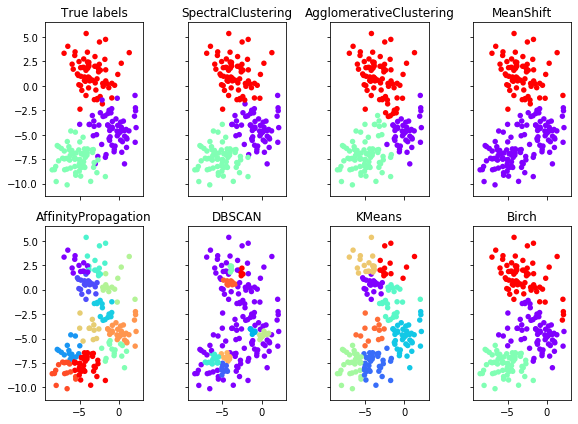

In [4]:
# plot clustering results using different methods
fig, axes = plt.subplots(2, 4,
                         figsize=(8, 6),
                         sharex=True,
                         sharey=True)

axes[0, 0].scatter(X[:, 0], X[:, 1],
                   c=y, s=30,
                   linewidths=0,
                   cmap=plt.cm.rainbow)
axes[0, 0].set_title("True labels")

for ax, est in zip(axes.flat[1:], [
    skc.SpectralClustering(3),
    skc.AgglomerativeClustering(3),
    skc.MeanShift(),
    skc.AffinityPropagation(),
    skc.DBSCAN(),
    skc.KMeans(),
    skc.Birch(),
]):
    est.fit(X)
    c = relabel(est.labels_)
    ax.scatter(X[:, 0], X[:, 1], c=c, s=30,
               linewidths=0, cmap=plt.cm.rainbow)
    ax.set_title(est.__class__.__name__)

# Fix the spacing between subplots.
fig.tight_layout()

So you may find that clustering results vary by approaches! If you want to know more about the parameters of specific approach, simply call `help` function to get your handy information, e.g., KMeans and DBSCAN.

In [6]:
# info. for KMeans
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'} or ndarray of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose k observations (row

In [7]:
# info. for DBSCAN
help(DBSCAN)

Help on class DBSCAN in module sklearn.cluster._dbscan:

class DBSCAN(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
 |  
 |  Perform DBSCAN clustering from vector array or distance matrix.
 |  
 |  DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
 |  Finds core samples of high density and expands clusters from them.
 |  Good for data which contains clusters of similar density.
 |  
 |  Read more in the :ref:`User Guide <dbscan>`.
 |  
 |  Parameters
 |  ----------
 |  eps : float, default=0.5
 |      The maximum distance between two samples for one to be considered
 |      as in the neighborhood of the other. This is not a maximum bound
 |      on the distances of points within a cluster. This is the most
 |      important DBSCAN parameter to choose appropriately for your data set
 |      and distance function.
 |  
 |  min_sample

What have you received? Shall we simply summarize that: KMeans is more distance-based, whilst DBSCAN is more density-based? Which approach will be more applicable to your project dataset then?

# <a id='Data Processing'>Data Processing<a/>

## Obtaining Geodemographic Data

For the sake of simplicity we're going to work with roughly the same set of data for London that Alexiou & Singleton used in their _Geodemographic Analysis_ chapter from [Geocomputation: A Practical Primer](https://uk.sagepub.com/en-gb/eur/geocomputation/book241023). Although the implementation in the _Primer_ is in the R programming language, the concerns and the approach are exactly the same.

### NomisWeb

In case you've forgotten, nearly the _entire_ Census is available to download from [InFuse](http://infuse2011.ukdataservice.ac.uk/), but you can often download data 'in bulk' from [NomisWeb](https://www.nomisweb.co.uk/home/detailedstats.asp?resume=no) directly. 

#### Demographic Data

The tables we want are:
* KS102EW: Age structure
* KS201EW: Ethnic group
* KS401EW: Dwellings, household space and accommodation type
* KS402EW: Tenure
* KS403EW: Rooms, bedrooms and central heating
* KS404EW: Car or van availability
* KS501EW: Qualifications and students
* KS603EW: Economic Activity by Sex

#### Geographic Areas

We want London LSOAs, which you can get by specifying 'Select areas within', then '2011 - super output areas - lower layers', and 'region' (leading to London). 

#### Saving Time

To save you the time of manually selecting and downloading each table, I have assembled everything into a '[Census.zip](https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/Census.zip?raw=true)' file. Upon your clicking, this will be automatically downloaded into your local directory, and please move it into your `data` folder, **you do _not_ need to unzip it**.

In [9]:
src = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/Census.zip?raw=true'
dst = 'data/Census.zip'

if not os.path.exists(dst):
    if not os.path.exists(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))
    
    r = requests.get(src, stream=True)
    
    with open(dst, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

print("Done.")

Done.


### ONS Boundary Data

We also need to download the LSOA boundary data. A quick Google search on "2011 LSOA boundaries" will lead you to the [Data.gov.uk portal](https://data.gov.uk/dataset/lower_layer_super_output_area_lsoa_boundaries). The rest is fairly straightforward:
* We want 'generalised' because that means that they've removed some of the detail from the boundaries so the file will load (and render) more quickly.
* We want 'clipped' because that means that the boundaries have been clipped to the edges of the land (e.g. the Thames; the 'Full' data set splits the Thames down the middle between adjacent LSOAs).

**_Note:_** be sure that you select the **2011** data, not the **2001** data.

#### Saving Time

Again, in order to get you started more quickly I've already created a 'pack' for you:

In [10]:
src = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/LSOAs.zip?raw=true'
dst = 'data/LSOAs.zip'
zpd = 'data/'

if not os.path.exists(dst):
    if not os.path.exists(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))
    
    r = requests.get(src, stream=True)
    
    with open(dst, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

if not os.path.exists(zpd):
    os.makedirs(os.path.dirname(zpd))
    
zp = zipfile.ZipFile(dst, 'r')
zp.extractall(zpd)
zp.close()    

print("Done.")

Done.


### Setup

If you _haven't_ used the automated download code above, then you should drag both the LSOA boundary file and the Census zipfile into a 'analysis' directory that is the same directory as this notebook so that they're easy to access. You should then:
* Unzip _only_ the LSOA zipfile.
* Rename the directory containing LSOA data to 'lsoa'.

And we're ready to go!

### Other Sources of Data

If you're more interested in US Census data then there's a nice-looking [wrapper to the Census API](https://pypi.python.org/pypi/census).

### Loading the Geodata

Unlike the NS-SeC data this is fairly straightforward using geopandas:

In [5]:
gdf = gpd.read_file('data/ Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp')
gdf.crs = {'init' :'epsg:27700'}
print("Shape of LSOA file: {0} rows by {1} columns".format(gdf.shape[0], gdf.shape[1]))
gdf.set_index('lsoa11cd', drop=True, inplace=True)
gdf.head(2)

Shape of LSOA file: 7166 rows by 5 columns


objectid             lsoa11nm            lsoa11nmw  \
lsoa11cd                                                        
E01000001         1  City of London 001A  City of London 001A   
E01000002         2  City of London 001B  City of London 001B   

                                                    geometry  
lsoa11cd                                                      
E01000001  POLYGON ((532106.894 182011.476, 532164.292 18...  
E01000002  POLYGON ((532748.624 181787.125, 532673.495 18...

### Loading the Census Data

You may need to make a few adjustments to the path to get the data loaded on your own computer. But notice what we're now able to do here: using the `zipfile` library we can extract a data file (or any other file) from the Zip archive without even having to open it. Saves even more time _and_ disk space!



In [6]:
z = zipfile.ZipFile(os.path.join('data','Census.zip'))
z.namelist()

['148410511-Dwellings.csv',
 '2596417429-Age.csv',
 '2653932334-Ethnicity.csv',
 '2735213988-Rooms.csv',
 '2790216173-Vehicles.csv',
 '2874717391-Tenure.csv',
 '3248615150-Qualifications.csv',
 '99521530-Activity.csv']

In [7]:
# We're going to save each data set to a
# separate data frame to make it easier
# to work with during cleaning
d = {}

for r in range(0, len(z.namelist())):
    
    m  = re.search("(?:-)([^\.]+)", z.namelist()[r])
    nm = m.group(1)
    
    print("Processing {0} file: ".format(nm))
    
    with z.open(z.namelist()[r]) as f:
                
        if z.namelist()[r] == '99521530-Activity.csv': 
            d[nm] = pd.read_csv(BytesIO(f.read()), header=7, skip_blank_lines=True, skipfooter=7, engine='python')
        else:
            d[nm] = pd.read_csv(BytesIO(f.read()), header=6, skip_blank_lines=True, skipfooter=7, engine='python')
    
    print("\tShape of dataframe is {0} rows by {1} columns".format(d[nm].shape[0], d[nm].shape[1]))

Processing Dwellings file: 
	Shape of dataframe is 4835 rows by 14 columns
Processing Age file: 
	Shape of dataframe is 4835 rows by 19 columns
Processing Ethnicity file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Rooms file: 
	Shape of dataframe is 4835 rows by 10 columns
Processing Vehicles file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Tenure file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Qualifications file: 
	Shape of dataframe is 4835 rows by 10 columns
Processing Activity file: 
	Shape of dataframe is 4835 rows by 11 columns


## Tidying Up

OK, that's a _lot_ of data! 4,835 rows and 88 columns. However, we don't know how much of this is redundant and so need to work out what might need removing from the data set before we can try clustering. So we're going to work our way through each data set in turn so that we can convert them to percentages before combining them into a single, large data set.

### Dwellings

From dewllings we're mainly interested in the housing type since we would expect that housing typologies will be a determinant of the types of people who live in an area. We _could_ look at places with no usual residents as well, or explore the distribution of shared dwellings, but this is a pretty good start.

In [8]:
t = 'Dwellings'

# If we find this column, this deletes it
if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

# List all of the columns    
d[t].columns

Index(['mnemonic', 'Unshared dwelling',
       'Shared dwelling: Two household spaces',
       'Shared dwelling: Three or more household spaces',
       'Household spaces with at least one usual resident',
       'Household spaces with no usual residents',
       'Whole house or bungalow: Detached',
       'Whole house or bungalow: Semi-detached',
       'Whole house or bungalow: Terraced (including end-terrace)',
       'Flat, maisonette or apartment: Purpose-built block of flats or tenement',
       'Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)',
       'Flat, maisonette or apartment: In a commercial building',
       'Caravan or other mobile or temporary structure'],
      dtype='object')

In [9]:
# Select the columns we're interested in analysing
selection = [u'Whole house or bungalow: Detached', u'Whole house or bungalow: Semi-detached',
       u'Whole house or bungalow: Terraced (including end-terrace)',
       u'Flat, maisonette or apartment: Purpose-built block of flats or tenement',
       u'Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)',
       u'Flat, maisonette or apartment: In a commercial building',
       u'Caravan or other mobile or temporary structure']

# We can't be sure how the totals add up 
# so it's best to generate our own based
# on the selection
d[t]['Total Properties'] = d[t].loc[:, selection].sum(axis=1)

In [10]:
# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    m  = re.search("^(?:[^\:]*)(?:\:\s)?(.+)$", c)
    nm = m.group(1)
    if nm == 'e':
        nm = 'Caravan'
    print("Renaming " + c + " to " + nm)
    d_pct[nm] = pd.Series(d[t][c].astype(float)/d[t]['Total Properties'].astype(float))

Renaming Whole house or bungalow: Detached to Detached
Renaming Whole house or bungalow: Semi-detached to Semi-detached
Renaming Whole house or bungalow: Terraced (including end-terrace) to Terraced (including end-terrace)
Renaming Flat, maisonette or apartment: Purpose-built block of flats or tenement to Purpose-built block of flats or tenement
Renaming Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits) to Part of a converted or shared house (including bed-sits)
Renaming Flat, maisonette or apartment: In a commercial building to In a commercial building
Renaming Caravan or other mobile or temporary structure to Caravan


In [12]:
d[t + '_pct'] = d_pct
d[t + '_pct'].sample(3)

mnemonic  Detached  Semi-detached  Terraced (including end-terrace)  \
2946  E01001022      0.36           0.58                              0.03   
2029  E01000270      0.13           0.33                              0.06   
4796  E01004439      0.02           0.15                              0.29   

      Purpose-built block of flats or tenement  \
2946                                      0.01   
2029                                      0.43   
4796                                      0.25   

      Part of a converted or shared house (including bed-sits)  \
2946                                               0.01          
2029                                               0.05          
4796                                               0.27          

      In a commercial building  Caravan  
2946                      0.00     0.00  
2029                      0.00     0.00  
4796                      0.01     0.00

### 2. Age
Clearly, some areas have more young people, some have older people, and some will be composed of families. A lot of these are going to be tied to 'lifestage' and so will help us to understand something about the types of areas in which they live.

In [13]:
t = 'Age'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

# List all of the columns    
d[t].columns

Index(['mnemonic', 'All usual residents', 'Age 0 to 4', 'Age 5 to 7',
       'Age 8 to 9', 'Age 10 to 14', 'Age 15', 'Age 16 to 17', 'Age 18 to 19',
       'Age 20 to 24', 'Age 25 to 29', 'Age 30 to 44', 'Age 45 to 59',
       'Age 60 to 64', 'Age 65 to 74', 'Age 75 to 84', 'Age 85 to 89',
       'Age 90 and over'],
      dtype='object')

In [14]:
# Derived columns
d[t]['Age 5 to 14']  = d[t]['Age 5 to 7'] + d[t]['Age 8 to 9'] + d[t]['Age 10 to 14'] 
d[t]['Age 15 to 24'] = d[t]['Age 15'] + d[t]['Age 16 to 17'] + d[t]['Age 18 to 19'] + d[t]['Age 20 to 24']
d[t]['Age 25 to 44'] = d[t]['Age 25 to 29'] + d[t]['Age 30 to 44']
d[t]['Age 45 to 64'] = d[t]['Age 45 to 59'] + d[t]['Age 60 to 64']
d[t]['Age 65+'] = d[t]['Age 65 to 74'] + d[t]['Age 75 to 84'] + d[t]['Age 85 to 89'] + d[t]['Age 90 and over']

# Select the columns we're interested in analysing
selection = ['Age 0 to 4','Age 5 to 14','Age 15 to 24',
             'Age 25 to 44','Age 45 to 64','Age 65+']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

mnemonic  Age 0 to 4  Age 5 to 14  Age 15 to 24  Age 25 to 44  \
1159  E01003588        0.08         0.14          0.20          0.34   
1545  E01004252        0.08         0.13          0.15          0.47   
802   E01003128        0.07         0.13          0.12          0.42   
3366  E01001632        0.08         0.11          0.19          0.38   
575   E01002730        0.05         0.06          0.18          0.46   

      Age 45 to 64  Age 65+  
1159          0.16     0.07  
1545          0.12     0.05  
802           0.20     0.06  
3366          0.19     0.05  
575           0.16     0.09

### 3. Ethnicity
We might also think that the balance of ethnic groups might impact a categorisation of LSOAs in London.

In [15]:
t = 'Ethnicity'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

# List all of the columns    
d[t].columns

Index(['mnemonic', 'All usual residents', 'White',
       'Mixed/multiple ethnic groups', 'Asian/Asian British',
       'Black/African/Caribbean/Black British', 'Other ethnic group'],
      dtype='object')

In [16]:
# Select the columns we're interested in analysing
selection = ['White', 'Mixed/multiple ethnic groups', 'Asian/Asian British', 
             'Black/African/Caribbean/Black British', 'Other ethnic group']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

mnemonic  White  Mixed/multiple ethnic groups  Asian/Asian British  \
3267  E01001485   0.42                          0.07                 0.12   
3897  E01002503   0.36                          0.03                 0.46   
4059  E01002601   0.70                          0.04                 0.18   
717   E01002865   0.72                          0.05                 0.11   
3012  E01001281   0.79                          0.05                 0.11   

      Black/African/Caribbean/Black British  Other ethnic group  
3267                                   0.32                0.07  
3897                                   0.10                0.04  
4059                                   0.06                0.02  
717                                    0.01                0.11  
3012                                   0.02                0.04

Similarly, the remaining .csv files would be read and processed respectively.

### 4. Rooms
Let's next incorporate the amount of space available to each household.

In [17]:
t = 'Rooms'

# If we find this column, this deletes it
if np.where(d[t].columns.values =='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

# List all of the columns    
d[t].columns

Index(['mnemonic', 'All categories: Type of central heating in household',
       'Does not have central heating', 'Does have central heating',
       'Occupancy rating (rooms) of -1 or less',
       'Occupancy rating (bedrooms) of -1 or less', 'Average household size',
       'Average number of rooms per household',
       'Average number of bedrooms per household'],
      dtype='object')

In [18]:
# Select the columns we're interested in analysing
selection = ['Does not have central heating', 'Occupancy rating (bedrooms) of -1 or less', 
             'Average household size', 'Average number of rooms per household']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
c = 'Does not have central heating'
d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Type of central heating in household'].astype(float))

c = 'Occupancy rating (bedrooms) of -1 or less'
d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Type of central heating in household'].astype(float))

c = 'Average household size'
d_pct[c] = pd.Series(d[t][c].astype(float))

c = 'Average number of rooms per household'
d_pct[c] = pd.Series(d[t][c].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

mnemonic  Does not have central heating  \
4615  E01004171                           0.01   
3880  E01002400                           0.01   
4041  E01002591                           0.03   
2620  E01000720                           0.06   
1219  E01003492                           0.05   

      Occupancy rating (bedrooms) of -1 or less  Average household size  \
4615                                       0.03                    2.70   
3880                                       0.12                    3.00   
4041                                       0.09                    2.80   
2620                                       0.08                    2.40   
1219                                       0.29                    3.80   

      Average number of rooms per household  
4615                                   5.60  
3880                                   5.10  
4041                                   5.10  
2620                                   4.90  
1219                                   5.10

### 5. Vehicles

Car ownership and use is also known to be a good predictor of social and economic 'status': Guy Lansley's article on the DLVA's registration database offers a useful perpective on the usefulness of this approach.

In [27]:
t = 'Vehicles'
# If we find this column, this deletes it
if np.where(d[t].columns.values == '2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)
# List all of the columns    
d[t].columns

Index(['mnemonic', 'All categories: Car or van availability',
       'No cars or vans in household', '1 car or van in household',
       '2 cars or vans in household', '3 cars or vans in household',
       '4 or more cars or vans in household'],
      dtype='object')

In [29]:
# Select the columns we're interested in analysing
selection = [u'No cars or vans in household', u'1 car or van in household',
       u'2 cars or vans in household', u'3 cars or vans in household',
       u'4 or more cars or vans in household']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Car or van availability'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

mnemonic  No cars or vans in household  1 car or van in household  \
4244  E01003366                          0.30                       0.49   
99    E01000946                          0.60                       0.29   
2369  E01000514                          0.23                       0.44   
6     E01000894                          0.39                       0.45   
1309  E01004033                          0.64                       0.30   

      2 cars or vans in household  3 cars or vans in household  \
4244                         0.15                         0.05   
99                           0.09                         0.02   
2369                         0.25                         0.05   
6                            0.12                         0.04   
1309                         0.05                         0.01   

      4 or more cars or vans in household  
4244                                 0.01  
99                                   0.00  
2369                                 0.02  
6                                    0.01  
1309                                 0.00

### 6. Tenure
Ownership structure is another categorisation predictor.

In [30]:
t = 'Tenure'
# If we find this column, this deletes it
if np.where(d[t].columns.values == '2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)
# List all of the columns    
d[t].columns

Index(['mnemonic', 'All households', 'Owned',
       'Shared ownership (part owned and part rented)', 'Social rented',
       'Private rented', 'Living rent free'],
      dtype='object')

In [32]:
# Select the columns we're interested in analysing
selection = [u'Owned', u'Shared ownership (part owned and part rented)', 
             u'Social rented', u'Private rented', u'Living rent free']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']],
    axis=1,
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All households'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

mnemonic  Owned  Shared ownership (part owned and part rented)  \
1236  E01003539   0.50                                           0.01   
3374  E01001574   0.23                                           0.01   
2025  E01000294   0.60                                           0.00   
3072  E01001200   0.58                                           0.00   
3041  E01001224   0.72                                           0.01   

      Social rented  Private rented  Living rent free  
1236           0.20            0.28              0.01  
3374           0.64            0.12              0.01  
2025           0.21            0.17              0.01  
3072           0.10            0.32              0.01  
3041           0.05            0.22              0.01

### 7. Qualifications

In [33]:
t = 'Qualifications'
# If we find this column, this deletes it
if np.where(d[t].columns.values == '2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)
# List all of the columns    
d[t].columns

Index(['mnemonic', 'All categories: Highest level of qualification',
       'No qualifications',
       'Highest level of qualification: Level 1 qualifications',
       'Highest level of qualification: Level 2 qualifications',
       'Highest level of qualification: Apprenticeship',
       'Highest level of qualification: Level 3 qualifications',
       'Highest level of qualification: Level 4 qualifications and above',
       'Highest level of qualification: Other qualifications'],
      dtype='object')

In [34]:
# Select the columns we're interested in analysing
selection = [u'No qualifications',
       u'Highest level of qualification: Level 1 qualifications',
       u'Highest level of qualification: Level 2 qualifications',
       u'Highest level of qualification: Apprenticeship',
       u'Highest level of qualification: Level 3 qualifications',
       u'Highest level of qualification: Level 4 qualifications and above',
       u'Highest level of qualification: Other qualifications']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']],
    axis=1,
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Highest level of qualification'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

mnemonic  No qualifications  \
2142  E01000297               0.15   
1056  E01003221               0.19   
1068  E01003257               0.20   
1586  E01032781               0.06   
1938  E01000036               0.25   

      Highest level of qualification: Level 1 qualifications  \
2142                                               0.09        
1056                                               0.11        
1068                                               0.09        
1586                                               0.05        
1938                                               0.16        

      Highest level of qualification: Level 2 qualifications  \
2142                                               0.09        
1056                                               0.15        
1068                                               0.12        
1586                                               0.06        
1938                                               0.15        

      Highest level of qualification: Apprenticeship  \
2142                                            0.01   
1056                                            0.01   
1068                                            0.01   
1586                                            0.01   
1938                                            0.02   

      Highest level of qualification: Level 3 qualifications  \
2142                                               0.10        
1056                                               0.10        
1068                                               0.09        
1586                                               0.05        
1938                                               0.10        

      Highest level of qualification: Level 4 qualifications and above  \
2142                                               0.43                  
1056                                               0.35                  
1068                                               0.43                  
1586                                               0.67                  
1938                                               0.23                  

      Highest level of qualification: Other qualifications  
2142                                               0.13     
1056                                               0.09     
1068                                               0.06     
1586                                               0.10     
1938                                               0.08

### 8. Activity

In [35]:
t = 'Activity'

# If we find this column, this deletes it
if np.where(d[t].columns.values == '2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)
# List all of the columns    
d[t].columns

Index(['mnemonic', 'All usual residents aged 16 to 74',
       'Economically active: In employment', 'Economically active: Unemployed',
       'Economically active: Full-time student',
       'Economically inactive: Retired',
       'Economically inactive: Student (including full-time students)',
       'Economically inactive: Looking after home or family',
       'Economically inactive: Long-term sick or disabled',
       'Economically inactive: Other'],
      dtype='object')

In [36]:
# Select the columns we're interested in analysing
selection = [u'Economically active: In employment',
       u'Economically active: Unemployed',
       u'Economically active: Full-time student',
       u'Economically inactive: Retired',
       u'Economically inactive: Looking after home or family',
       u'Economically inactive: Long-term sick or disabled',
       u'Economically inactive: Other']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']],
    axis=1,
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    m = re.search("^Eco.*?active: (.+)$", c)
    nm = m.group(1)
    d_pct[nm] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents aged 16 to 74'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

mnemonic  In employment  Unemployed  Full-time student  Retired  \
1026  E01003228           0.75        0.04               0.02     0.08   
2619  E01000719           0.65        0.05               0.01     0.10   
4733  E01004399           0.48        0.08               0.04     0.08   
487   E01002070           0.61        0.07               0.04     0.06   
3835  E01002514           0.69        0.02               0.04     0.10   

      Looking after home or family  Long-term sick or disabled  Other  
1026                          0.03                        0.04   0.02  
2619                          0.07                        0.04   0.02  
4733                          0.09                        0.07   0.05  
487                           0.05                        0.05   0.05  
3835                          0.03                        0.02   0.02

## Bringing it All Together

Now that we've standardised everything using percentages, it's time to bring the data together! We'll initialise the data frame using the first matching data set, and then iterate over the rest, merging the data frames as we go.

In [41]:
matching = [s for s in d.keys() if "_pct" in s]
print(matching)

lsoac = d[matching[0]]

for m in range(1, len(matching)):
    lsoac = lsoac.merge(d[matching[m]], how='inner', left_on='mnemonic', right_on='mnemonic')

['Dwellings_pct', 'Age_pct', 'Ethnicity_pct', 'Rooms_pct', 'Vehicles_pct', 'Tenure_pct', 'Qualifications_pct', 'Activity_pct']


In [42]:
# Change the index
lsoac.set_index('mnemonic', drop=True, inplace=True)
lsoac.index.name = None

In [43]:
print(lsoac.columns.values)

['Detached' 'Semi-detached' 'Terraced (including end-terrace)'
 'Purpose-built block of flats or tenement'
 'Part of a converted or shared house (including bed-sits)'
 'In a commercial building' 'Caravan' 'Age 0 to 4' 'Age 5 to 14'
 'Age 15 to 24' 'Age 25 to 44' 'Age 45 to 64' 'Age 65+' 'White'
 'Mixed/multiple ethnic groups' 'Asian/Asian British'
 'Black/African/Caribbean/Black British' 'Other ethnic group'
 'Does not have central heating'
 'Occupancy rating (bedrooms) of -1 or less' 'Average household size'
 'Average number of rooms per household' 'No cars or vans in household'
 '1 car or van in household' '2 cars or vans in household'
 '3 cars or vans in household' '4 or more cars or vans in household'
 'Owned' 'Shared ownership (part owned and part rented)' 'Social rented'
 'Private rented' 'Living rent free' 'No qualifications'
 'Highest level of qualification: Level 1 qualifications'
 'Highest level of qualification: Level 2 qualifications'
 'Highest level of qualification: Appre

In [44]:
print("Shape of full data frame is {0} by {1}".format(lsoac.shape[0], lsoac.shape[1]))

Shape of full data frame is 4835 by 46


## <a id='Removing Badly-Behaved Variables'>Removing Badly-Behaved Variables<a/>

Some of these variables will be very difficult to work with because they are so strongly skewed. We can test the degree to which this is a problem fairly easily in pandas.

As we create a "outputs" folder by following codes, figures generated hereafter will be stored in this directory, and you may want to check them if interested.

In [45]:
if os.path.isdir('output') is not True:
    print("Creating 'outputs' directory for images.")
    os.mkdir('output')

col_pos=0
for c in lsoac.columns.values:
    print("Creating chart for " + c)
    nm = c.replace("/", "-")
    fig, ax = plt.subplots()
    fig.set_size_inches(7,4)
    sns.distplot(lsoac[c])
    fig.savefig(os.path.join('output', "Untransformed-" + str(col_pos) + "." + nm + '.png'))
    plt.close(fig)
    col_pos += 1

Creating 'outputs' directory for images.
Creating chart for Detached
Creating chart for Semi-detached
Creating chart for Terraced (including end-terrace)
Creating chart for Purpose-built block of flats or tenement
Creating chart for Part of a converted or shared house (including bed-sits)
Creating chart for In a commercial building
Creating chart for Caravan
Creating chart for Age 0 to 4
Creating chart for Age 5 to 14
Creating chart for Age 15 to 24
Creating chart for Age 25 to 44
Creating chart for Age 45 to 64
Creating chart for Age 65+
Creating chart for White
Creating chart for Mixed/multiple ethnic groups
Creating chart for Asian/Asian British
Creating chart for Black/African/Caribbean/Black British
Creating chart for Other ethnic group
Creating chart for Does not have central heating
Creating chart for Occupancy rating (bedrooms) of -1 or less
Creating chart for Average household size
Creating chart for Average number of rooms per household
Creating chart for No cars or vans in h

Dozens of variables have been plotted, and we want a summary of the skewness by variables in this dataframe.

Text(0.5, 1.0, 'Skew by Variable for Raw Data')

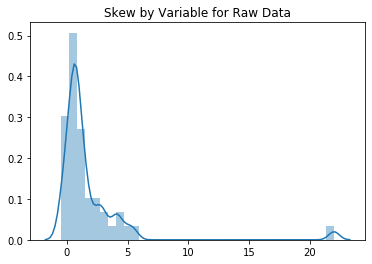

In [46]:
sns.distplot(lsoac.skew(axis=0, numeric_only=True).values).set_title("Skew by Variable for Raw Data")

There are obviously highly skewed variables (the bins larger than 5 in above distplot), and we don't want to include them into our model, so just drop them by:

In [47]:
sk = lsoac.skew(axis=0, numeric_only=True)
to_drop = sk[sk >= 5].index
print("Dropping highly-skewed variables: " + ", ".join(to_drop.values))
lsoac.drop(to_drop.values, axis=1, inplace=True)

Dropping highly-skewed variables: Caravan, Other


We bring you an important tool **pickle** today, and you may find it handy in the following codes.

In [48]:
# The pickle is a 'live' Python class written to 
# disk -- so it's easy to re-load the data and get 
# moving again. In other words, if you change your
# mind about anything you've done later, you can just
# re-start your analysis from the next code block
lsoac.to_pickle(os.path.join('data','LSOAC.pickle'))
del(lsoac)

In [49]:
lsoac = pd.read_pickle(os.path.join('data','LSOAC.pickle'))

## <a id='Normalization'>Normalization<a/>

For data processing before any "real" analysis, normalization via log or Box-Cox transformation happens _after_ the variables have been converted to percentages, so that's what I've done here. I think that this approach is debatable as it's potentially harder to deal with zeroes in the data _after_ converting to a percentage than it was before. The reason that zeroes are an issue is that the log of 0.0 is `-Inf` or `NaN`, so this blows up in your cluster analysis if you don't deal with it now. The easiest way to do this is to simply add `1` to every raw count, ensuring that the smallest value in your data set is always positive. If you had already converted to a percentage then adding 0.000001% to only the zero values still changes the actual distribution, while adding 0.000001% to all values could leave you with percentages over 100!

In [19]:
lsoac = pd.read_pickle(os.path.join('data','LSOAC.pickle'))
numeric_cols = [col for col in lsoac if lsoac[col].dtype.kind != 'O']
lsoac[numeric_cols] += 1
print("Numeric columns: " + ", ".join(numeric_cols))

Numeric columns: Detached, Semi-detached, Terraced (including end-terrace), Purpose-built block of flats or tenement, Part of a converted or shared house (including bed-sits), In a commercial building, Age 0 to 4, Age 5 to 14, Age 15 to 24, Age 25 to 44, Age 45 to 64, Age 65+, White, Mixed/multiple ethnic groups, Asian/Asian British, Black/African/Caribbean/Black British, Other ethnic group, Does not have central heating, Occupancy rating (bedrooms) of -1 or less, Average household size, Average number of rooms per household, No cars or vans in household, 1 car or van in household, 2 cars or vans in household, 3 cars or vans in household, 4 or more cars or vans in household, Owned, Shared ownership (part owned and part rented), Social rented, Private rented, Living rent free, No qualifications, Highest level of qualification: Level 1 qualifications, Highest level of qualification: Level 2 qualifications, Highest level of qualification: Apprenticeship, Highest level of qualification: Le

In [51]:
lsoac['Does not have central heating'].min()

1.0

In [52]:
from scipy.stats import boxcox

col_pos = 0
for c in lsoac.columns:
    if lsoac[c].dtype.kind != 'O':
        print("Transforming " + c)
        x, _ = boxcox( lsoac[c] )
        nm = c.replace("/", "-")
        fig, ax = plt.subplots()
        fig.set_size_inches(7,4)
        sns.distplot(x, hist=True)
        fig.savefig(os.path.join('output', "Box-Cox-" + str(col_pos) + "." + nm + '.png'))
        plt.close(fig)
        col_pos += 1
        lsoac[c] = pd.Series(x, index=lsoac.index)

Transforming Detached
Transforming Semi-detached
Transforming Terraced (including end-terrace)
Transforming Purpose-built block of flats or tenement
Transforming Part of a converted or shared house (including bed-sits)
Transforming In a commercial building
Transforming Age 0 to 4
Transforming Age 5 to 14
Transforming Age 15 to 24
Transforming Age 25 to 44
Transforming Age 45 to 64
Transforming Age 65+
Transforming White
Transforming Mixed/multiple ethnic groups
Transforming Asian/Asian British
Transforming Black/African/Caribbean/Black British
Transforming Other ethnic group
Transforming Does not have central heating
Transforming Occupancy rating (bedrooms) of -1 or less
Transforming Average household size
Transforming Average number of rooms per household
Transforming No cars or vans in household
Transforming 1 car or van in household
Transforming 2 cars or vans in household
Transforming 3 cars or vans in household
Transforming 4 or more cars or vans in household
Transforming Owned
Tr

Again,your transformed data are in the "Outputs" folder, you may want to have a look at the scale for axis.

## <a id='Removing Correlated Variables'>Removing Correlated Variables<a/>

We don't want to keep too many correlated variables in the clustering data since that will bias the clustering algorithms and may result in poor 'performance' in terms of cluster quality (it will be equivalent to some features getting double-weighted!). The best way to do this is to produce a correlation table for all variables and then look to remove problematic variables.

In [20]:
lsoac.corr()

) of -1 or less                                                        0.73      
Average household size                                                                           0.36      
Average number of rooms per household                                                           -0.36      
No cars or vans in household                                                                     0.38      
1 car or van in household                                                                       -0.28      
2 cars or vans in household                                                                     -0.37      
3 cars or vans in household                                                                     -0.29      
4 or more cars or vans in household                                                             -0.28      
Owned                                                                                           -0.42      
Shared ownership (part owned and part rented)                                                    0.13      
Social rented                                                                                    0.17      
Private rented                                                                                   0.45      
Living rent free                                                                                 0.25      
No qualifications                                                                                0.09      
Highest level of qualification: Level 1 qualifi...                                              -0.10      
Highest level of qualification: Level 2 qualifi...                                              -0.31      
Highest level of qualification: Apprenticeship                                                  -0.44      
Highest level of qualification: Level 3 qualifi...                                              -0.17      
Highest level of qualification: Level 4 qualifi...                                              -0.16      
Highest level of qualification: Other qualifica...                                               1.00      
In employment                                                                                   -0.42      
Unemployed                                                                                       0.38      
Full-time student                                                                                0.45      
Retired                                                                                         -0.42      
Looking after home or family                                                                     0.38      
Long-term sick or disabled                                                                       0.23      

                                                    In employment  Unemployed  \
Detached                                                     0.05       -0.33   
Semi-detached                                                0.09       -0.32   
Terraced (including end-terrace)                            -0.01        0.05   
Purpose-built block of flats or tenement                    -0.26        0.39   
Part of a converted or shared house (including ...           0.32       -0.09   
In a commercial building                                     0.10       -0.05   
Age 0 to 4                                                  -0.24        0.47   
Age 5 to 14                                                 -0.52        0.45   
Age 15 to 24                                                -0.64        0.28   
Age 25 to 44                                                 0.39        0.04   
Age 45 to 64                                                 0.19       -0.38   
Age 65+                                                      0.11       -0.44   
White                                                        0.62       -0.60   
Mixed/multiple ethnic groups                                -0.14        0.45   
As

In [24]:
corrs    = 0.50 # What's our threshold for strongly correlated?
corrh    = 0.70 # What's our threshold for highly correlated?

# Generate the matrix but capture the output this time
corrm = lsoac.corr()
corrm['name'] = corrm.index # We need a copy of the index

num_corrs = []
hi_corrs  = []

for c in corrm.columns:
    if c != 'name':
        hits = corrm.loc[(abs(corrm[c]) >= corrs) & (abs(corrm[c]) < 1.0), c]
        # Some formatting
        print("=" * 20 + " " + c + " " + "=" * 20)
        
        if hits.size == 0: # No correlations > corrs
            print("Not strongly correlated (>=" + str(corrs) + ") with other variables.")
        else:
            num_corrs.append(hits.size)
            
            if hits[ abs(hits) <= corrh ].size > 1:
                print("Strongly correlated with: ")
                print("\t" + ", ".join(hits[ hits <= corrh ].index.values))
            
            if hits[ abs(hits) > corrh ].size > 1:
                print("Highly correlated with: ")
                print("\t" + ", ".join(hits[ hits > corrh ].index.values))
                hi_corrs.append(hits[ hits > corrh ].size)

==================== Detached ====================
Strongly correlated with: 
	Age 65+, Average number of rooms per household, No cars or vans in household, 2 cars or vans in household, 3 cars or vans in household, Retired
==================== Semi-detached ====================
Strongly correlated with: 
	Purpose-built block of flats or tenement, Age 25 to 44, Age 45 to 64, Age 65+, Average number of rooms per household, No cars or vans in household, 4 or more cars or vans in household, Highest level of qualification: Level 2 qualifications, Highest level of qualification: Apprenticeship, Retired
Highly correlated with: 
	2 cars or vans in household, 3 cars or vans in household, Owned
==================== Terraced (including end-terrace) ====================
==================== Purpose-built block of flats or tenement ====================
Strongly correlated with: 
	Semi-detached, Terraced (including end-terrace), Age 45 to 64, Average number of rooms per household, 1 car or van in ho

Text(0.5, 1.0, 'Number of Strong (> 0.5) Correlations with Other Variables')

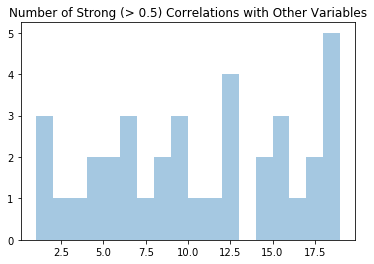

In [55]:
sns.distplot(num_corrs, bins=range(1,20), kde=False).set_title("Number of Strong (> " + str(corrs) + ") Correlations with Other Variables")

Text(0.5, 1.0, 'Number of Very Strong Correlations (> 0.7)  with Other Variables')

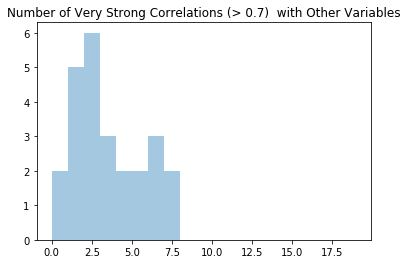

In [56]:
sns.distplot(hi_corrs, bins=range(0,20), kde=False).set_title("Number of Very Strong Correlations (> " + str(corrh) + ")  with Other Variables")

### Stripping Out 'Redundant' Variables

Let's remove any variable that has either:
1. A '*lot*' of correlations in excess of 0.50, though we need to define what is 'a lot'.
2. A correlation higher than 0.70 with at least one other variable that is already in our 'to keep list.

This will reduce the dimensionality of our data and allow us to then focus on normalisation. An alternative approach to dimensionality reduction -- which would be more 'robust', though harder for many to understand -- would be to apply **Principal Components Analysis (PCA)** to the data set and to work with the eigenvalues afterwards. `PCA` is available in `sklearn`.

In [25]:
maxcorrs  = 5 # What's our threshold for too many strong correlations?

to_drop = [] # Columns to drop
to_keep = [] # Columns to keep

for c in corrm.columns:
    if c != 'name':
        
        hits = corrm.loc[(abs(corrm[c]) >= corrs) & (abs(corrm[c]) < 1.0), c]
        
        print("=" * 12 + " " + c + " " + "=" * 12)
        print(hits)
        print(" ")
        
        hi_vals    = False
        multi_vals = False
        
        # Remove ones with very high correlations
        if hits[ abs(hits) > corrh ].size > 0:
            print(">>> Very high correlation...")
            s1 = set(to_keep)
            s2 = set(hits[ abs(hits) > corrh ].index.values)
            #print("Comparing to_keep(" + ", ".join(s1) + ") to hits(" + ", ".join(s2) + ")")
            s1 &= s2
            #print("Column found in 'very high correlations': " + str(s1))
            if len(s1) > 1: 
                hi_vals = True
                print("Will drop '" + c + "' because of very high correlation with retained cols: \n\t" + "\n\t".join(s1))
        
        # Remove ones with many correlations
        if hits.size >= maxcorrs: 
            print(">>> Many correlations...")
            s1 = set(to_keep)
            s2 = set(hits.index.values)
            #print("Comparing to_keep(" + ", ".join(s1) + ") to hits(" + ", ".join(s2) + ")")
            s1 &= s2
            #print("Column found in 'many correlations' :" + str(s1))
            if len(s1) > 1: 
                multi_vals = True
                print("Will drop '" + c + "' because of multiple strong correlations with retained cols: \n\t" + "\n\t".join(s1))
        
        if hi_vals==True or multi_vals==True:
            to_drop.append(c)
        else:
            to_keep.append(c)

print(" ")
print("To drop: " + ", ".join(to_drop))
print(" ")
print("To keep: " + ", ".join(to_keep))

..
============ 2 cars or vans in household ============
Detached                                                  0.62
Semi-detached                                             0.77
Purpose-built block of flats or tenement                 -0.67
Age 25 to 44                                             -0.68
Age 45 to 64                                              0.75
Age 65+                                                   0.65
Mixed/multiple ethnic groups                             -0.57
Occupancy rating (bedrooms) of -1 or less                -0.58
Average number of rooms per household                     0.88
No cars or vans in household                             -0.94
3 cars or vans in household                               0.92
4 or more cars or vans in household                       0.81
Owned                                                     0.90
Social rented                                            -0.62
Private rented                                           -0.5

At the end of the output above, you will get a list of variables to drop and variables to keep, let's print out the list for retained variables in our model:

In [26]:
lsoacf = lsoac.drop(to_drop, axis=1, errors='raise')
print("Retained variables: " + ", ".join(lsoacf.columns.values))

Retained variables: Detached, Semi-detached, Terraced (including end-terrace), Part of a converted or shared house (including bed-sits), In a commercial building, Age 0 to 4, Age 5 to 14, Age 15 to 24, Age 45 to 64, White, Mixed/multiple ethnic groups, Asian/Asian British, Other ethnic group, Does not have central heating, Average household size, 1 car or van in household, Shared ownership (part owned and part rented), Social rented, Living rent free, Highest level of qualification: Level 3 qualifications, Highest level of qualification: Other qualifications, Full-time student, Looking after home or family, Long-term sick or disabled


In [91]:
lsoacf.columns

Index(['Detached', 'Semi-detached', 'Terraced (including end-terrace)',
       'Part of a converted or shared house (including bed-sits)',
       'In a commercial building', 'Age 0 to 4', 'Age 5 to 14', 'Age 15 to 24',
       'White', 'Mixed/multiple ethnic groups', 'Asian/Asian British',
       'Other ethnic group', 'Does not have central heating',
       '1 car or van in household',
       'Shared ownership (part owned and part rented)', 'Living rent free',
       'No qualifications',
       'Highest level of qualification: Level 3 qualifications',
       'Looking after home or family', 'Long-term sick or disabled'],
      dtype='object')

## <a id='Standardising the Data'>Standardising the Data<a/>
The effectiveness of clustering algorithms is usually demonstrated using the 'iris data' -- it's available by default with both Seaborn and SciKit-Learn. This data doesn't usually need normalisation but it's a good way to start looking at the data across four dimensions and seeing how it varies and why some dimensions are 'good' for clustering, while others are 'not useful'...

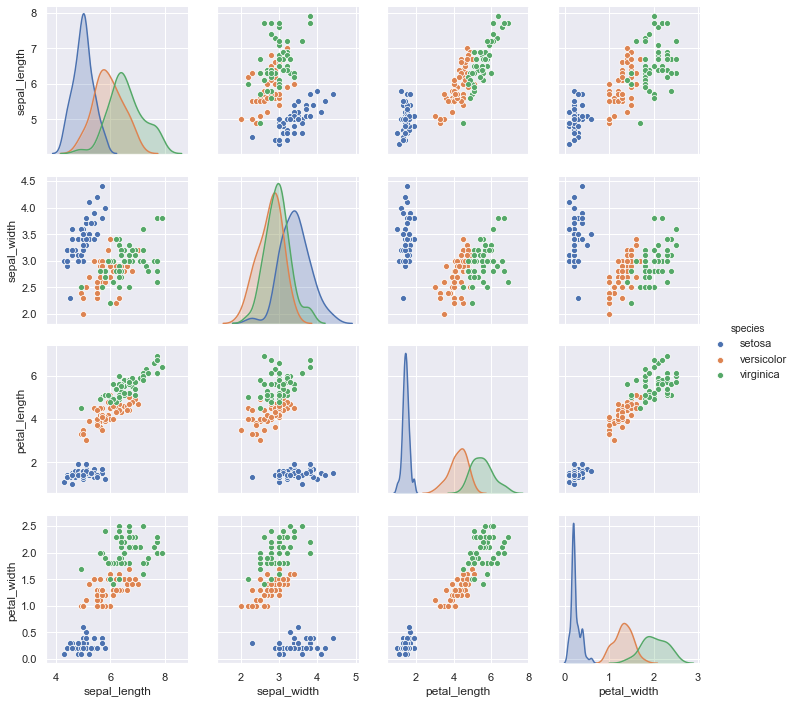

In [59]:
sns.set()
irises = sns.load_dataset("iris")
sns.pairplot(irises, hue="species")

### Why Standardise

One of the main challenges of clustering, however, is that the scale of each dimension matters: if you were to try to cluster, for example, [1] how many metres per year a glacier moved with [2] the number of cubic metres by which it grew, then you would only be clustering on variable [2]. 

That's because glaciers contain millions of cubic metres of ice and will grow or shrink by thousands of cubic metres each year. In contrast, most glaciers move at most a few metres per year. So the sheer scale difference between these two dimensions means that the values of variable 1 dominate the clustering algorithm because they provide a much better 'spread' in the data than variable 2.

To address this we need to standardise the data in some way so that the scales are relatively consistent. There's no _one_ way to standardise the data, it depends on the characteristics of the data _as well as_ what we're looking for in terms of clustering. As a general rule, we're _aiming_ for a normal (a.k.a. Gaussian) distribution with 0 mean and unit variance. The latter part of this is what most people focus on: you may recall our work with transformations last year, and here's one more reason why it's useful. That said, normalisation (making the data 'look' normal) can also be very important for the process since it can significantly skew the results as well if the data itself is heavily skewed.

Right, so does this all sound a little bit familiar from last year? Let's start by just looking at a few variables in a simple scatter plot...

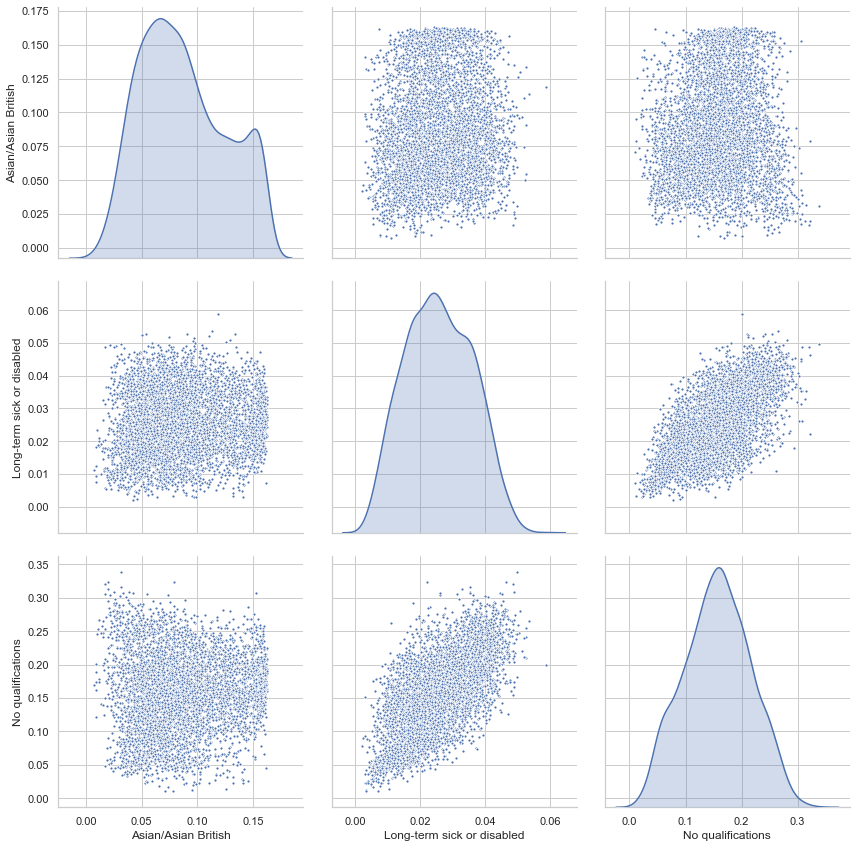

In [60]:
# The data as it is now...
sns.set(style="whitegrid")
sns.pairplot(lsoacf, 
             vars=[
                'Asian/Asian British',
                'Long-term sick or disabled',
                'No qualifications'], 
             markers=".", height=4, diag_kind='kde')

So there are clearly some differences, but I'd be hard-pressed to give you sensible clusters just by looking at this data.

### Standardisation with `sklearn`

Let's try standardising the data now:

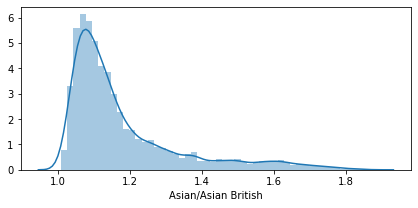

In [27]:
plt.rcParams['figure.figsize']=(7,3)
sns.distplot(lsoacf['Asian/Asian British'])

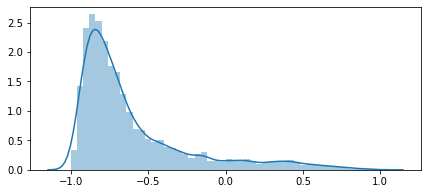

In [28]:
sns.distplot(
    preprocessing.minmax_scale(lsoacf['Asian/Asian British'].values.reshape(-1,1), feature_range=(-1.0, 1.0)))

In [30]:
# Full copy, not copy by reference
df = lsoacf.copy(deep=True)

# An alternative if you'd like to try it
#scaler = preprocessing.RobustScaler(quantile_range=[5.0, 95.0])
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

df[to_keep] = scaler.fit_transform(df[to_keep])

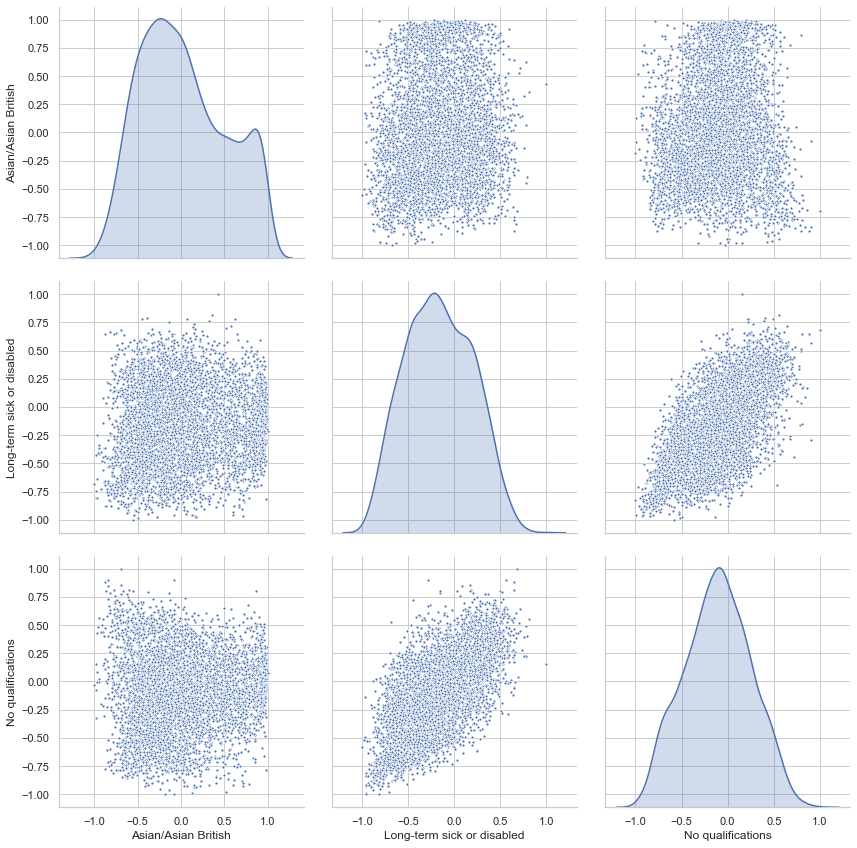

In [62]:
# still the same 3 variables, but standardised.....
# The data as it is now...
sns.pairplot(df, 
             vars=['Asian/Asian British','Long-term sick or disabled','No qualifications'], 
             markers=".", height=4, diag_kind='kde')

Right, so you can see that robustly rescaling the dimension hasn't *actually* changed the relationships within each dimension, or even between dimensions, but it has changed the overall range so that the the data is broadly re-centered on 0 but we *still* have the original outliers from the raw data. You could _also_ do IQR standardisation (0.25 and 0.75) with the percentages, but in those cases you would have _more_ outliers and then _more_ extreme values skewing the results of the clustering algorithm.

### A Step Too Far?

The standardisation process has given us a better perspective on _where_ high concentrations of different groups might be found, but we still need to decide whether the clustering or other machine learning processes should be influenced by the full range of the data. I followed the approach outlined in _Geocomputation_, but in some ways I lean towards _not_ completely rescaling on the basis that super-high concentrations of particular groups _should_ have a significant impact on the results of the clustering process; however, using robust rescaling (allowing outliers to persist) does mean that we're more likely to get one large cluster containing the bulk of the non-extreme data and a number of small clusters each containing a small number of 'extreme' LSOAs. **Can you think why?**

My point is that the right choice is the one that you can argue logically and consistently for. There are plenty of researchers who would disagree with me on the paragraph above, but that doesn't mean I'm wrong. Nor does it mean they're wrong.

# <a id='Clustering Realization'>Clustering Realization<a/>
## Let's Cluster!

OK, we're finally here! It's time to cluster the cleaned, normalised, and standardised data set! We're going to start with the best-know clustering technique and work from there...

### K-Means

In [63]:
from sklearn.cluster import KMeans
#help(KMeans)
df.head(3)

Detached  Semi-detached  Terraced (including end-terrace)  \
E01000907     -0.48          -0.70                             -0.29   
E01000908     -0.58          -0.40                             -0.80   
E01000909      0.56           0.09                             -0.53   

           Part of a converted or shared house (including bed-sits)  \
E01000907                                               0.38          
E01000908                                               0.10          
E01000909                                               0.53          

           In a commercial building  Age 0 to 4  Age 5 to 14  Age 15 to 24  \
E01000907                     -1.00       -0.06        -0.06         -0.15   
E01000908                     -0.55       -0.13        -0.19         -0.36   
E01000909                     -0.11       -0.33        -0.35         -0.16   

           White  Mixed/multiple ethnic groups  Asian/Asian British  \
E01000907   0.30                          0.22                -0.26   
E01000908   0.28                          0.41                -0.45   
E01000909   0.59                         -0.04                -0.58   

           Other ethnic group  Does not have central heating  \
E01000907               -0.10                          -0.37   
E01000908                0.26                           0.63   
E01000909               -0.07                          -0.05   

           1 car or van in household  \
E01000907                      -0.45   
E01000908                      -0.40   
E01000909                      -0.01   

           Shared ownership (part owned and part rented)  Living rent free  \
E01000907                                          -0.30             -0.36   
E01000908                                          -0.70              0.17   
E01000909                                           0.03              0.44   

           No qualifications  \
E01000907               0.01   
E01000908              -0.23   
E01000909              -0.51   

           Highest level of qualification: Level 3 qualifications  \
E01000907                                               0.12        
E01000908                                               0.08        
E01000909                                               0.18        

           Looking after home or family  Long-term sick or disabled  
E01000907                          0.21                        0.43  
E01000908                         -0.03                        0.37  
E01000909                         -0.12                       -0.01

The next few code blocks may take a while to complete, largely because of the `pairplot` at the end where we ask Seaborn to plot every dimension against every other dimension _while_ colouring the points according to their cluster. I've reduced the plotting to just three dimensions, if you want to plot all of them, then just replace the array attached to `vars` with `main_cols`, but you have to bear in mind that that is plotting 4,300 points _each_ time it draws a plot... and there are 81 of them! It'll take a while, but it _will_ do it, and try doing that in Excel or SPSS?

In [64]:
df.columns.values

array(['Detached', 'Semi-detached', 'Terraced (including end-terrace)',
       'Part of a converted or shared house (including bed-sits)',
       'In a commercial building', 'Age 0 to 4', 'Age 5 to 14',
       'Age 15 to 24', 'White', 'Mixed/multiple ethnic groups',
       'Asian/Asian British', 'Other ethnic group',
       'Does not have central heating', '1 car or van in household',
       'Shared ownership (part owned and part rented)',
       'Living rent free', 'No qualifications',
       'Highest level of qualification: Level 3 qualifications',
       'Looking after home or family', 'Long-term sick or disabled'],
      dtype=object)

[1 1 4 ... 3 3 3]


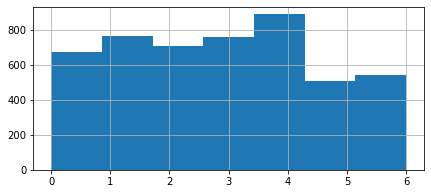

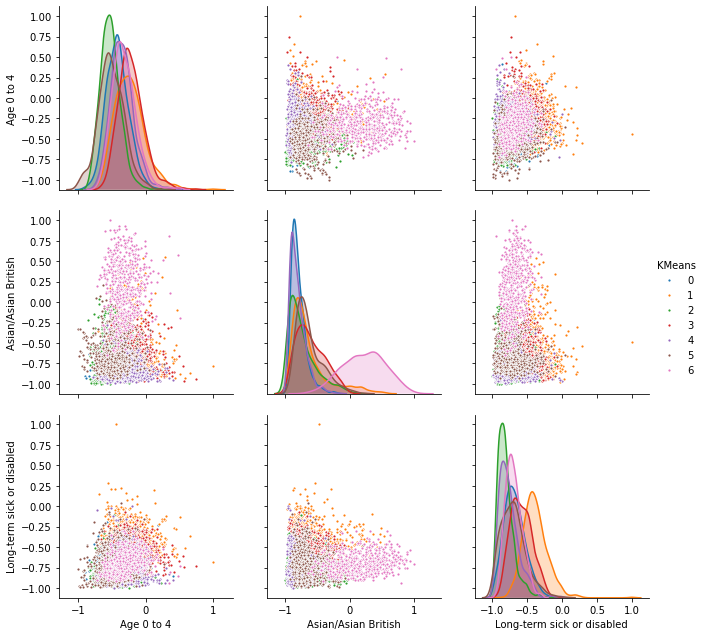

In [31]:
# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
df.drop(list(df.columns[df.isnull().any().values].values), axis=1, inplace=True)

k      = 7 # Number of clusters
k_var  = 'KMeans' # Variable name
kmeans = KMeans(n_clusters=k).fit(df) # The process

print(kmeans.labels_) # The results

# Add it to the data frame
df[k_var] = pd.Series(kmeans.labels_, index=df.index) 

# How are the clusters distributed?
df.KMeans.hist(bins=k)

# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a 
# few
sns.pairplot(df, 
             vars=['Age 0 to 4','Asian/Asian British','Long-term sick or disabled'], 
             hue=k_var, markers=".", height=3, diag_kind='kde')

### One More Thing...

There's just _one_ little problem: what assumption did I make when I started this *k*-means cluster analysis? It's a huge one, and it's one of the reasons that *k*-means clustering _can_ be problematic when used naively...

<span style="color:red;font-weight:bold;font-style:italic">**_Discuss the answer to this question with your neighbour._**</span>

### The Silhouette Plot vs Within-Cluster Sum of Squares

Again, there's more than one way to skin this cat. In _Geocomputation_ they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (`2...n`) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always _some_ benefit to adding more clusters (the perfect clustering is _k==n_), so you don't always see a knee. 

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM). 

Either way, to evaluate this in a systematic way, we want to do _multiple_ _k_-means clusterings for _multiple_ values of _k_ and then we can look at which gives the best results...

Let's try it for the range 3-9.

Cluster count: 3
For k = 3 The average silhouette_score is : 0.29487830473520155


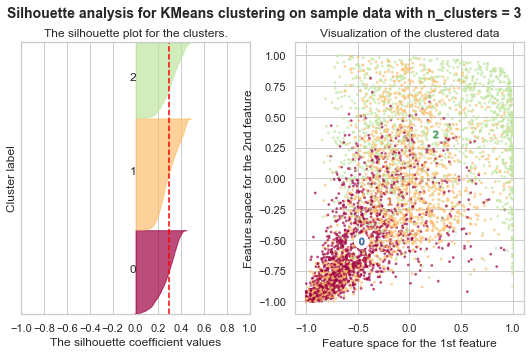

Cluster count: 4
For k = 4 The average silhouette_score is : 0.3025038323386832


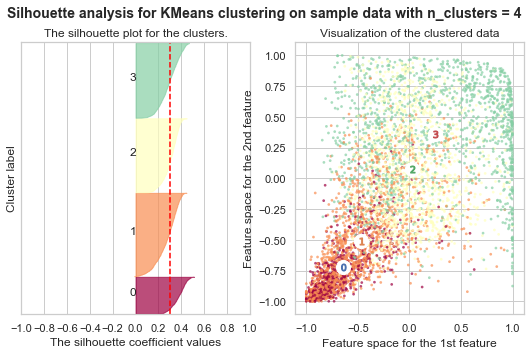

Cluster count: 5
For k = 5 The average silhouette_score is : 0.29626898610775726


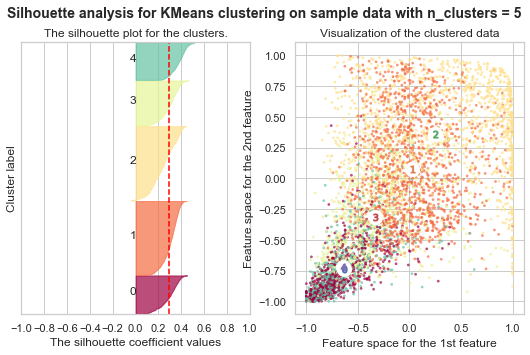

Cluster count: 6
For k = 6 The average silhouette_score is : 0.28740298575268475


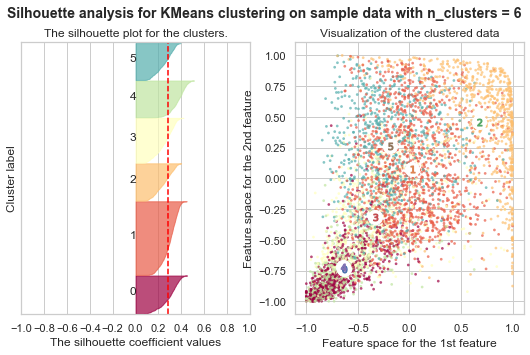

Cluster count: 7
For k = 7 The average silhouette_score is : 0.26610826678085264


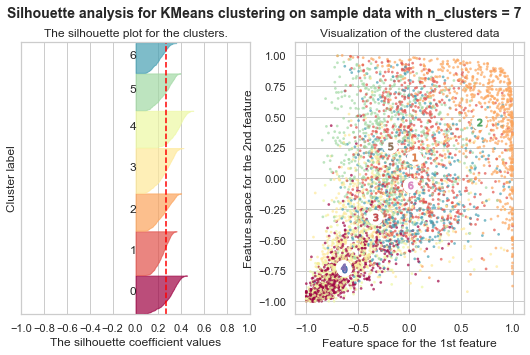

Cluster count: 8
For k = 8 The average silhouette_score is : 0.24430178503216413


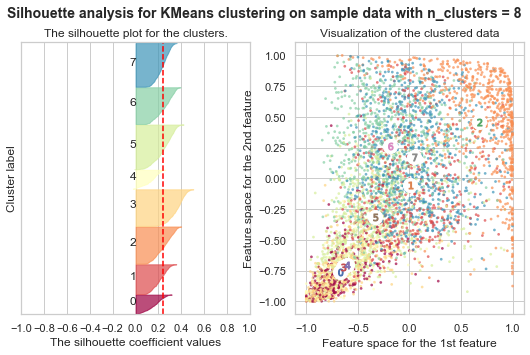

Cluster count: 9
For k = 9 The average silhouette_score is : 0.22441988973104915


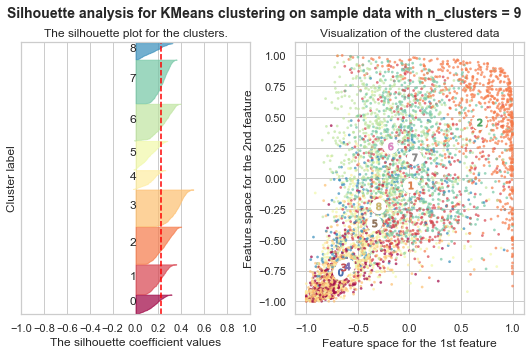

In [66]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

for k in range(3,10):
    # Debugging
    print("Cluster count: " + str(k))
    
    #############
    # Do the clustering using the main columns
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(df)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(df, cluster_labels)
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)
    
    # Calculate the silhouette values
    sample_silhouette_values = silhouette_samples(df, cluster_labels)
    
    #############
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, df.shape[0] + (k + 1) * 10])
    
    y_lower = 10
    
    # For each of the clusters...
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Set the color ramp
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = cm.Spectral(cluster_labels.astype(float) / k)
    ax2.scatter(df[df.columns[0]], df[df.columns[1]], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

    plt.show()

### Interpreting the Results

When I ran *k*-means, the results suggested that 5 clusters was probably 'best' -- but note that that's only if we don't have any kind of underlying _theory_, other _empirical evidence_, or just a _reason_ for choosing a different value... Again, we're now getting in areas where _your judgement_ and your ability to _communicate your rationale_ to readers is the key thing. 

Let's repeat the 5-cluster process and then map it.

In [32]:
# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
df.drop(list(df.columns[df.isnull().any().values].values), axis=1, inplace=True)

k_pref = 5
kmeans = KMeans(n_clusters=k_pref).fit(df)
df[k_var] = pd.Series(kmeans.labels_, index=df.index)

sdf = gdf.join(df, how='inner')


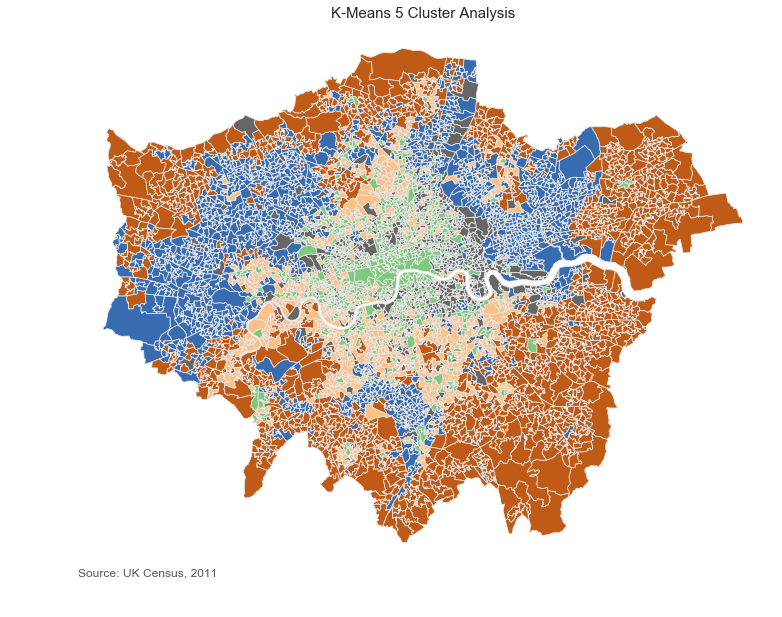

In [67]:
# set up the plot configuration
fig, ax = plt.subplots(1, figsize=(14, 10))
# get the map
sdf.plot(column=k_var, cmap='Accent', linewidth=0.8, ax=ax, edgecolor='0.9')
# map title
ax.set_title('K-Means ' + str(k_pref) + ' Cluster Analysis', fontdict={'fontsize': '15', 'fontweight': '2'})
# create an annotation for the data source
ax.annotate('Source: UK Census, 2011',xy=(0.1,.08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# turn off the axis
ax.axis('off')
# save your figure into local directory
fig.savefig('outputs/K-Means.png', dpi=150)

To make sense of whether this is a 'good' result, you might want to visit [datashine](http://datashine.org.uk/#table=QS607EW&col=QS607EW0050&ramp=RdYlGn&layers=BTTT&zoom=10&lon=-0.1751&lat=51.4863) or think back to last year when we examined the NS-SeC data. 

You could also think of ways of plotting how these groups differ. For instance...

### *Really, really important*

Now would be a good time to think about _how_ standardisation and normalisation would have changed your results... and you might want to test whether applying these in a 'stronger' format (e.g. sklearn's `robust_rescale` and scipy's `boxcox`) help or hinder your analysis!

In [68]:
df.to_pickle(os.path.join("data","clusters.pickle"))

## <a id='Ward Clustering'>Ward Clustering<a/>
One of the more helpful & flexible clusterers in `scikit-learn` is the ward agglomerative clusterer, which aims to build good clusters from pairwise aggregations of data.

(500656.3628764128, 564877.8210842896, 153596.51574565732, 203188.13880917354)

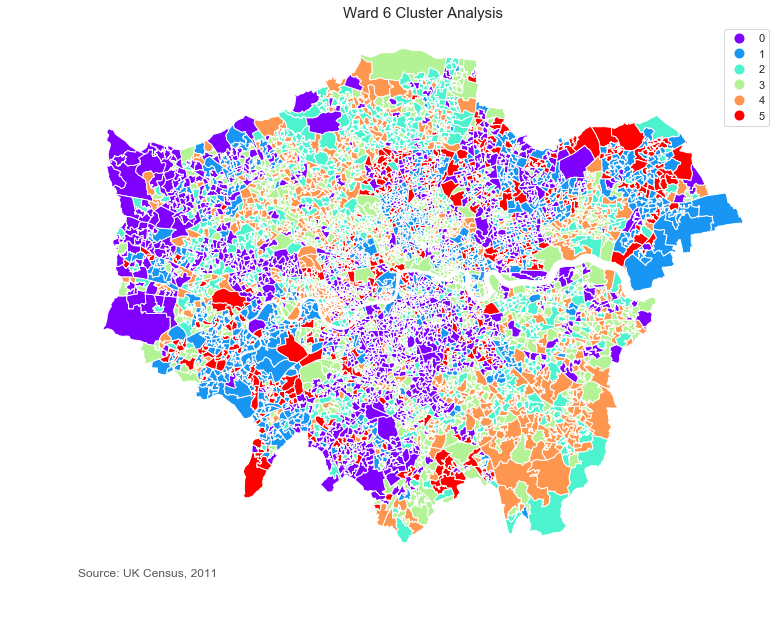

In [69]:
w_var='Ward'
# ward cluster
ward = skc.AgglomerativeClustering(n_clusters=6).fit(df) # define the number of clusters
df[w_var] = pd.DataFrame(ward.labels_, index=df.index)  

# set up the plot configuration
fig, ax = plt.subplots(1, figsize=(14, 10))

# get the map
sdf.assign(labels=ward.labels_).plot('labels', cmap='rainbow', categorical=True, legend=True, ax=ax)
# map title
ax.set_title('Ward ' + str(6) + ' Cluster Analysis', fontdict={'fontsize': '15', 'fontweight': '2'})
# create an annotation for the data source
ax.annotate('Source: UK Census, 2011',xy=(0.1,.08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# turn off the axis
ax.axis('off')
# save your figure into local directory
# fig.savefig('Ward.png', dpi=150)

## <a id='DBSCAN Clustering'>DBSCAN Clustering<a/>
    
For DBSCAN, it is a local density-based scan clusterer; like other scikit estimators, data are split into an initialization set and a fit set. It works by fitting clusters of nearby points using the `eps` distance, which is the furthest distance at which points are considered to be in each other's clusters.

we don't need to specify the number of clusters in advance, which sounds great, but we still need to specify _other_ parameters and these can have a huge impact on our results!

In [78]:
d_var = 'DBSCAN'

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
df.drop(list(df.columns[df.isnull().any().values].values), axis=1, inplace=True)

from sklearn.cluster import DBSCAN

# Run the clustering
dbs = DBSCAN(eps=1, min_samples=10).fit(df.values)

# See how we did
df[d_var] = pd.Series(dbs.labels_, index=df.index)
print(df[d_var].value_counts())

-1    2443
 3     674
 6     477
 0     372
 1     329
 4     304
 2     202
 5      34
Name: DBSCAN, dtype: int64


In [79]:
dbs.components_ # Copy of each core sample found by training

array([[-0.63792398, -0.71417601, -0.0733242 , ...,  1.        ,
         3.        ,  0.        ],
       [-0.80574188, -0.64183369,  0.21206922, ...,  1.        ,
         3.        ,  0.        ],
       [-0.61238609, -0.64481191, -0.18465123, ...,  0.        ,
         4.        ,  1.        ],
       ...,
       [ 0.17900258, -0.40587357,  0.74122766, ...,  2.        ,
         0.        ,  3.        ],
       [ 0.22406707, -0.42333623,  0.83709624, ...,  2.        ,
         0.        ,  3.        ],
       [ 0.08792291, -0.31776425,  0.71842553, ...,  2.        ,
         0.        ,  3.        ]])

It also contains the indices of the observations found to be "cores" of the clusters detected:

In [72]:
dbs.core_sample_indices_ # Indices of core samples

array([  11,   13,   14,   22,   24,   25,   26,   27,   29,   35,   41,
         43,   49,   50,   64,   69,   78,   83,   95,  144,  161,  174,
        175,  181,  184,  187,  188,  190,  193,  196,  198,  200,  201,
        202,  204,  205,  207,  210,  211,  212,  214,  215,  216,  221,
        223,  226,  227,  229,  233,  235,  239,  245,  247,  256,  258,
        263,  277,  279,  289,  290,  291,  296,  297,  298,  299,  301,
        303,  304,  306,  310,  311,  321,  325,  338,  340,  342,  345,
        346,  347,  348,  357,  358,  377,  380,  385,  397,  398,  399,
        406,  414,  416,  417,  420,  423,  438,  449,  455,  460,  462,
        468,  477,  482,  484,  486,  487,  489,  497,  498,  502,  504,
        513,  515,  526,  530,  533,  534,  542,  545,  548,  552,  553,
        554,  555,  556,  560,  563,  564,  569,  571,  575,  576,  580,
        583,  585,  586,  606,  607,  608,  611,  627,  628,  630,  631,
        651,  676,  679,  680,  689,  700,  718,  7

As well as their labels, which are the quantity of interest here, the main thing we wanted to detect:

In [73]:
dbs.labels_ # Cluster labels for each point in the dataset given to fit

array([-1, -1, -1, ...,  3,  3,  3])

Now that we've got the clustering results we can join it to the Shapefile data (from the geopandas dataframe) and save  it as a new Shapefile containing the new columns.

In [75]:
sdf = gdf.join(df, how='inner')

sdf.sample(5)[[k_var, w_var, d_var]]

KMeans  Ward  DBSCAN
E01032580       2     0      -1
E01004648       0     4      -1
E01001154       2     0       3
E01002056       0     4       1
E01000490       0     4       1

(500656.3628764128, 564877.8210842896, 153596.51574565732, 203188.13880917354)

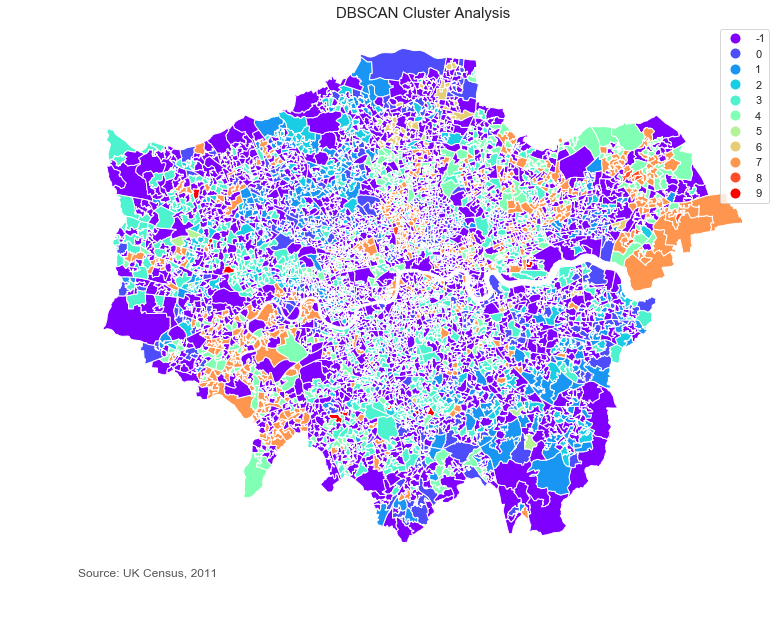

In [77]:
# set up the plot configuration
fig, ax = plt.subplots(1, figsize=(14, 10))

# get the map
sdf.assign(cl=dbs.labels_).plot(column='cl', cmap='rainbow', categorical=True, legend=True, ax=ax)
# map title
ax.set_title('DBSCAN' + ' Cluster Analysis', fontdict={'fontsize': '15', 'fontweight': '2'})
# create an annotation for the data source
ax.annotate('Source: UK Census, 2011',xy=(0.1,.08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# turn off the axis
ax.axis('off')
# save your figure into local directory
# fig.savefig('outputs/DBSCAN.png', dpi=150)

### Note!

Note that you now have the results of the clustering process saved in a shapefile and could then load it into a GIS. Or you could also save the `df` file to a pickle for futher analysis...

In [80]:
df.to_pickle(os.path.join("data","clusters.pickle"))

## Self-Organising Maps

SOMs offer a third type of clustering algorithm. They are a relatively 'simple' type of neural network in which the 'map' (of the SOM) adjusts to the data: we're going to see how this works over the next few code blocks, but the main thing is that, unlike the above approaches, SOMs build a 2D map of a higher-dimensional space and use this as a mechanism for subsequently clustering the raw data.

In [33]:
from sompy.sompy import SOMFactory

s_var = 'SOM'
gdf = gpd.read_file(os.path.join('data','LSOA_IMD2019.shp'))
gdf.crs = {'init' :'epsg:27700'}
gdf.set_index('lsoa11nm', drop=True, inplace=True)
df = pd.read_pickle(os.path.join("data","clusters.pickle"))
df.sample(2)

Entering env context: <fiona.env.Env object at 0x12f0f6410>
Starting outermost env
No GDAL environment exists
New GDAL environment <fiona._env.GDALEnv object at 0x12f0f6750> created
Logging error handler pushed.
All drivers registered.
GDAL data files are available at built-in paths
PROJ data files are available at built-in paths
Started GDALEnv <fiona._env.GDALEnv object at 0x12f0f6750>.
Updated existing <fiona._env.GDALEnv object at 0x12f0f6750> with options {}
Entered env context: <fiona.env.Env object at 0x12f0f6410>
Got coordinate system
Got coordinate system
Index: 0
Flushed buffer
Stopped session
Exiting env context: <fiona.env.Env object at 0x12f0f6410>
Cleared existing <fiona._env.GDALEnv object at 0x12f0f6750> options
Stopping GDALEnv <fiona._env.GDALEnv object at 0x12f0f6750>.
Error handler popped.
Stopped GDALEnv <fiona._env.GDALEnv object at 0x12f0f6750>.
Exiting outermost env
Exited env context: <fiona.env.Env object at 0x12f0f6410>


Detached  Semi-detached  Terraced (including end-terrace)  \
E01002355     -0.42           0.25                              0.79   
E01004471     -0.27          -0.34                             -0.03   

           Part of a converted or shared house (including bed-sits)  \
E01002355                                              -0.95          
E01004471                                               0.09          

           In a commercial building  Age 0 to 4  Age 5 to 14  Age 15 to 24  \
E01002355                     -0.09       -0.16        -0.04         -0.31   
E01004471                     -0.87        0.31         0.00         -0.15   

           White  Mixed/multiple ethnic groups  ...  \
E01002355   0.79                         -0.58  ...   
E01004471  -0.28                         -0.11  ...   

           1 car or van in household  \
E01002355                       0.29   
E01004471                      -0.16   

           Shared ownership (part owned and part rented)  Living rent free  \
E01002355                                          -1.00             -0.62   
E01004471                                          -0.33              0.03   

           No qualifications  \
E01002355              -0.02   
E01004471               0.23   

           Highest level of qualification: Level 3 qualifications  \
E01002355                                               0.49        
E01004471                                               0.16        

           Looking after home or family  Long-term sick or disabled  KMeans  \
E01002355                         -0.21                       -0.31       3   
E01004471                          0.33                        0.19       2   

           Ward  DBSCAN  
E01002355     1      -1  
E01004471     0      -1  

[2 rows x 23 columns]

In [83]:
k_var  = 'KMeans'
d_var  = 'DBSCAN'

data  = df.drop([k_var,d_var], axis=1).values
names = df.columns.values
print(data[1:2,])

[[-0.58360604 -0.39552081 -0.7955728   0.09632044 -0.54784609 -0.12933535
  -0.18539586 -0.36382282  0.27605647  0.4066014  -0.44554753  0.25829229
   0.62657205 -0.40038528 -0.69578954  0.17074795 -0.23303413  0.08065365
  -0.02641905  0.3682876   3.        ]]


Next, we are going to actually train the SOM using the input data. This is where you specify the input parameters that have the main effect on the clustering results:

In [84]:
sm = SOMFactory().build(
    data, mapsize=(10,15),
    normalization='var', initialization='random', component_names=names)
sm.train(n_job=4, verbose=False, train_rough_len=2, train_finetune_len=5)

How good is the fit?

In [85]:
topographic_error  = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print("Topographic error = {0:0.5f}; Quantization error = {1:0.5f}".format(topographic_error, quantization_error))

Topographic error = 0.26225; Quantization error = 2.87359


How do the results look?

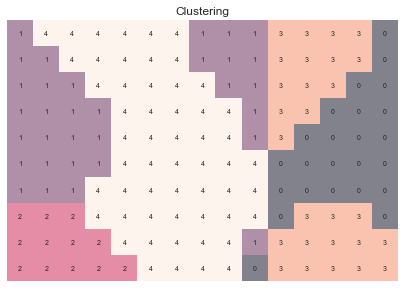

In [86]:
k_val = 5

from sompy.visualization.hitmap import HitMapView

sm.cluster(k_val)
hits  = HitMapView(7, 7, "Clustering", text_size=9)
a     = hits.show(sm)

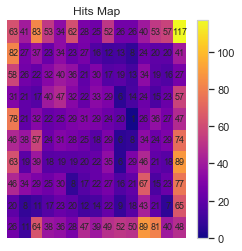

In [87]:
from sompy.visualization.bmuhits import BmuHitsView
vhts = BmuHitsView(4, 4, "Hits Map", text_size=11)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=9, cmap="plasma", logaritmic=False)

In [95]:
# Get the labels for each BMU
# in the SOM (15 * 10 neurons)
clabs = sm.cluster_labels

# Project the data on to the SOM
# so that we get the BMU for each
# of the original data points
bmus  = sm.project_data(data)

# Turn the BMUs into cluster labels
# and append to the data frame
df[s_var] = pd.Series(clabs[bmus], index=df.index)

print(df.SOM.value_counts())

sdf = gdf.merge(df[[k_var, w_var, d_var, s_var]], how='inner', left_on='lsoa11cd', right_index=True)

sdf.sample(5)[[k_var, w_var, d_var, s_var]]

4    1502
3    1021
1     927
0     841
2     544
Name: SOM, dtype: int64


KMeans  Ward  DBSCAN  SOM
lsoa11nm                                     
Lambeth 003E             4     2       2    4
Hillingdon 009B          3     1       6    0
Tower Hamlets 022D       4     2       5    1
Hackney 026D             4     2      -1    1
Sutton 002C              3     5       4    2

<p style="font-family: Calibri; font-size:2.0em;color:red";>Optional!</p>

To get it plotted as a map, we call the similar function from **matplotlib**. However it really takes time for SOM clustering! So in case you would like to save the time, I've attached my map below for your information. 

<img src="som_cluster_map.png">


(500648.73535646376, 564874.625514253, 153603.41393440694, 203187.7232412195)

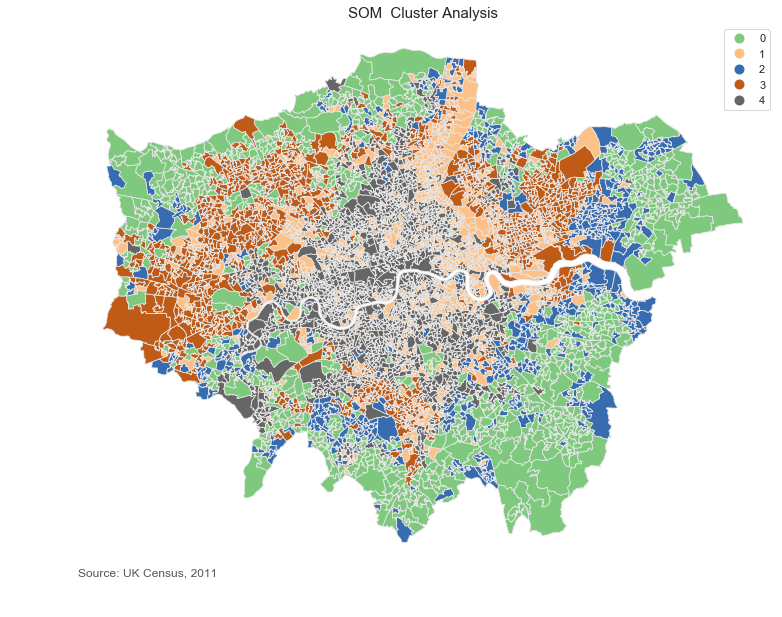

In [96]:
# set up the plot configuration
fig, ax = plt.subplots(1, figsize=(14, 10))
# get the map
sdf.plot(column=s_var, cmap='Accent', linewidth=0.8, ax=ax, edgecolor='0.9', categorical=True, legend=True)
# map title
ax.set_title('SOM ' + ' Cluster Analysis', fontdict={'fontsize': '15', 'fontweight': '2'})
# create an annotation for the data source
ax.annotate('Source: UK Census, 2011',xy=(0.1,.08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# turn off the axis
ax.axis('off')
# save your figure into local directory
# fig.savefig('outputs/SOM.png', dpi=150)

## Wrap-Up

You've reached the end, you're done... 

Er, no. This is barely scratching the surface! I'd suggest that you go back through the above code and do three things:
1. Add a lot more comments to the code to ensure that really have understood what is going on.
2. Try playing with some of the parameters (e.g. my thresholds for skew, or non-normality) and seeing how your results change.
3. Try outputting additional plots that will help you to understand the _quality_ of your clustering results (e.g. what _is_ the makeup of cluster 1? Or 6? What has it picked up? What names would I give these clsuters?).

If all of that seems like a lot of work then why not learn a bit more about machine learning before calling it a day?

See: [Introduction to Machine Learning with Scikit-Learn](http://www.slideshare.net/BenjaminBengfort/introduction-to-machine-learning-with-scikitlearn).

## Credits!

#### Contributors:
The following individuals have contributed to these teaching materials: Yijing Li (yijing.li@kcl.ac.uk), Jon Reades (jonathan.reades@kcl.ac.uk)

#### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).